# Sistemas Distribuidos
## Primera evaluacion

Se evaluaran los siguientes puntos:

### Importar datos

1. Adquirir los datos.
> * El conjunto de datos con el que van a trabajar esta disponibles en [este enlace](https://archive.org/download/nycTaxiTripData2013/trip_data.7z) y consiste en 12 archivos de texto que tiene informacion del viajes de taxis en la ciudad de NY durante el 2013.
> * En la red interna de LANIA usando cable la descarga del archivo comprimido desde el enlace tomó entre 5 y 10 minutos. Tomen sus provisiones
> * El archivo comprimido tiene un tamaño de aproximadamente 4G, el tamaño de archivo mensual oscila entre 2.0 y 2.5G. La base de datos completa es de aproximadamente 30G.
2. Una vez descargado el archivo pueden descomprimirlo usando la siguiente instruccion
>` !7z x trip_data.7z -o/content/`
sin embargo si intentan descomprimir todos los archivos en su sesion se van a terminar el espacio de disco disponible. En esta practica solo van a trabajar con datos correspondientes a los primeros cuatro meses. 
3. Responder las siguientes preguntas:
   1. Cuantas columnas contiene cada archivo de datos descomprimido
   2. Cuantos renglones tiene cada archivo
4. Identificar si existen renglones con errores en los datos, por ejemplo si hay columnas de mas (o de menos), si hay campos vacios, etc. Si se detectan renglones con errores:
    1. indicar claramente cuantos son los renglones con errores y a que archivos corresponden
    2. crear un nuevo conjunto de datos con los errores eliminados
5. Crear un `DataFrame` usando la libreria `pandas` y responder lo siguiente:
   1. Indicar el tiempo en segundos, que  tarda la libreria `pandas` en leer un archivo a un  `DataFrame`
   2. Cual es la huella de memoria del proceso usado para generar el objeto `DataFrame`
   2. Cuanta memoria del sistema se usa para crear el objeto anterior
   3. Indicar el tiempo que tarda `pandas` en obtener el promedio de la distancia de viaje (`trip_distance`)
6. Todos los pasos siguientes deben **realizarse** usando la libreria `dask`
   3. Indicar el tiempo que tarda en obtener el promedio de la distancia de viaje (`trip_distance`)
   3. Indicar el tiempo que tarda en obtener el promedio de la duracion de viaje (`trip_time_in_secs`)
   4. Con las columnas `pickup_datetime` y `dropoff_datetime` como objetos temporales, crear una nueva columna en los dataframes que se llame `duracion` y compararla renglon a renglon con la columna `trip_time_in_secs`
   5. Definir un `viaje_largo` como aquellos en los que la duracion del viaje (`trip_time_in_secs`) sea mayor a 20 minutos.
7. Contar el numero de viajes largos en cada archivo
8. De los viajes largos, identificar el numero de taxis diferentes (la columna `medallion` contiene un numeroque identificada a cada uno de los vehiculos). Que vehiculos son los que mas viajes realizan en cada mes? Son el mismo vehiculo?
9. Hacer una grafica temporal del numero total de pasajeros agregados por dias de la semana y despues por horas del dia. Sugerencia: agregar por el correspondiente periodo temporal y graficar. Que pueden observar de las graficas?
10. Elegir el vehiculo con mas viajes en cada mes y graficar en un mapa los sitios donde se suben pasajeros agrupados por
   * dia de la semana (un color distinto para cada dia)
   * hora del dia (un color distinto para cada intervalo de cuatro horas,00:00 - 03:59, 04:00--07:59, 08:00-11:59, etc.)
11. Repetir para las posiciones donde se bajan los pasajeros para el mismo vehiculo.

Aguilar Hernández Joaquín

Código desarrollado con: 
* Valenzuela Carrasco Georgina
* Cobos Trujillo José David
* Hernández Jiménez Luis Daniel
* Báez Herrera Samuel
* Giddings Soto Lorrain Eugenio
* Campos Sacramento Yoselin Araceli
* Reyes Hernández Ana Margarita
* Martínez Arteaga Alexis
* Sosa Medellín Adrian
* Tapia McClung Horacio

##Adquisición de datos

In [0]:
import pandas as pd
import time, psutil, os, gdal, gc
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [0]:
gc.enable()

In [0]:
!wget  https://archive.org/download/nycTaxiTripData2013/trip_data.7z

--2019-06-26 23:29:50--  https://archive.org/download/nycTaxiTripData2013/trip_data.7z
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia802501.us.archive.org/1/items/nycTaxiTripData2013/trip_data.7z [following]
--2019-06-26 23:29:50--  https://ia802501.us.archive.org/1/items/nycTaxiTripData2013/trip_data.7z
Resolving ia802501.us.archive.org (ia802501.us.archive.org)... 207.241.228.191
Connecting to ia802501.us.archive.org (ia802501.us.archive.org)|207.241.228.191|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4102781969 (3.8G) [application/x-7z-compressed]
Saving to: ‘trip_data.7z’

trip_data.7z        100%[===================>]   3.82G  7.59MB/s    in 4m 56s  

2019-06-26 23:34:46 (13.2 MB/s) - ‘trip_data.7z’ saved [4102781969/4102781969]



In [0]:
plantilla='trip_data_{:01d}.csv'
files=[plantilla.format(month) for month in range(1,13)]

In [0]:
def descomprimir_archivo(fileName):  
  plantilla7z='7z x trip_data.7z  -o/content '+ fileName
  os.system(plantilla7z)
  data=dd.read_csv(file,low_memory=False, parse_dates=True, usecols=['medallion','pickup_datetime','dropoff_datetime','passenger_count',
                          'trip_time_in_secs','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],header=0, dtype={'trip_distance': 'float64','trip_time_in_secs': 'int64', 'medallion': 'str', 'passenger_count': 'int64','pickup_longitude': 'float64','pickup_latitude':'float64','dropoff_longitude': 'float64', 'dropoff_latitude':'float64'}).compute()
  os.system('rm '+fileName)  
  return data

In [0]:
def leer_archivo(fileName):
  plantilla7z='7z x trip_data.7z  -o/content '+ fileName
  #print (plantilla7z)
  os.system(plantilla7z)
  data=dd.read_csv(file,low_memory=False, parse_dates=True, dtype={' store_and_fwd_flag':'object'}).compute()
  os.system('rm '+fileName)  
  return data

#3. Responder las siguientes preguntas:
   1. Cuantas columnas contiene cada archivo de datos descomprimido
   2. Cuantos renglones tiene cada archivo

In [0]:
dfColumnas_renglones=pd.DataFrame(columns=['Name','Columns','Rows'])

In [0]:
for file in files:
  df=leer_archivo(file)
  total_rows=len(df.axes[0])
  total_cols=len(df.axes[1])
  new_row=pd.DataFrame({'Name' : file , 'Columns' : total_cols, 'Rows':total_rows},index=[0])  
  dfColumnas_renglones=pd.concat([new_row,dfColumnas_renglones]).reset_index(drop=True)

In [0]:
dfColumnas_renglones.sort_values(by=['Name'])
dfColumnas_renglones.head(12)

,Name,Columns,Rows
0,trip_data_12.csv,14,13971118
1,trip_data_11.csv,14,14388451
2,trip_data_10.csv,14,15004556
3,trip_data_9.csv,14,14107693
4,trip_data_8.csv,14,12597109
5,trip_data_7.csv,14,13823840
6,trip_data_6.csv,14,14385456
7,trip_data_5.csv,14,15285049
8,trip_data_4.csv,14,15100468
9,trip_data_3.csv,14,15749228


#4. Identificar si existen renglones con errores en los datos, por ejemplo si hay columnas de mas (o de menos), si hay campos vacios, etc. Si se detectan renglones con errores:
    1. indicar claramente cuantos son los renglones con errores y a que archivos corresponden
    2. crear un nuevo conjunto de datos con los errores eliminados






In [0]:
#files =[plantilla.format(month) for month in range(1,13)]

In [0]:
#dfLimpiar =  pd.DataFrame(columns=['Name', 'Columns', 'Rows','CantNulos','FueraRangoPasaje','FueraRangoNY','FueraMillas','RowsFinales'])

In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive' ,force_remount=True)

In [0]:
#quedafiltros=[]

In [0]:
#def limpiarDataFrame(df):
 #   a=len(df.axes[0])
#    df=df.dropna()
    #df = df[(df['passenger_count'] >0) & (df['passenger_count'] <= 7)]
 #   quedafiltros.append(a-len(df.axes[0]))
   # a=len(df.axes[0])
    #df=df.dropna()
   # df = df[(df['passenger_count'] >0) & (df['passenger_count'] <= 7)]
 #   quedafiltros.append(a-len(df.axes[0]))
  #  a=len(df.axes[0])
 #   df=df[(df['pickup_latitude'] >40.496136) & (df['pickup_latitude'] <40.897877) & (df['pickup_longitude'] >-74.269459)& (df['pickup_longitude'] <-73.690606)]
   # quedafiltros.append(a-len(df.axes[0]))
   # a=len(df.axes[0])
#df = df[(df['trip_distance'] <=100)]
#    quedafiltros.append(a-len(df.axes[0]))
    #return df

In [0]:
#Proceso de limpieza de datos se realiza sobre todos los datos del archivo original
#for file in files:  
#  df=leer_archivo(file)
 # a=limpiarDataFrame(df)
 # fname=file
#  a.to_csv(fname)  
 # gzipCommand="gzip "+fname  
#  os.system(gzipCommand)  
#  gzipName=fname+".gz"
#  os.system( "mv "+gzipName +" \"/content/gdrive/My Drive/Colab Notebooks/"+gzipName+"\"") 
 # total_rows=len(df.axes[0])
#  total_cols=len(df.axes[1])
  #new_row=pd.DataFrame({'Name' : file , 'Columns' : total_cols, 'Rows':total_rows,'CantNulos':quedafiltros[0],'FueraRangoPasaje':quedafiltros[1],'FueraRangoNY':quedafiltros[2],'FueraMillas':quedafiltros[3],'RowsFinales':total_rows-(quedafiltros[0]+quedafiltros[1]+quedafiltros[2]+quedafiltros[3])},index=[0])
  #quedafiltros=[]
  #dfLimpiar=pd.concat([new_row,dfLimpiar]).reset_index(drop=True)

In [0]:
#dfLimpiar

In [0]:
df.dtypes

medallion               object
 hack_license           object
 vendor_id              object
 rate_code               int64
 store_and_fwd_flag     object
 pickup_datetime        object
 dropoff_datetime       object
 passenger_count         int64
 trip_time_in_secs       int64
 trip_distance         float64
 pickup_longitude      float64
 pickup_latitude       float64
 dropoff_longitude     float64
 dropoff_latitude      float64
dtype: object

In [0]:
df.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,D7D598CD99978BD012A87A76A7C891B7,82F90D5EFE52FDFD2FDEC3EAD6D5771D,VTS,1,NaN,2013-12-01 00:13:00,2013-12-01 00:31:00,1,1080,3.90,-73.979340,40.776653,-73.981865,40.734280
1,5455D5FF2BD94D10B304A15D4B7F2735,177B80B867CEC990DA166BA1D0FCAF82,VTS,1,NaN,2013-12-01 00:40:00,2013-12-01 00:48:00,6,480,3.20,-73.939674,40.726154,-73.985580,40.718075
2,93D6821F86A12B537C5EADBDFB432CA7,28B0AA10202F83FEB0F4E69340CA8F86,VTS,1,NaN,2013-12-01 02:21:00,2013-12-01 02:30:00,5,540,3.28,-73.958755,40.768078,-73.958755,40.768078
3,0C107B532C1207A74F0D8609B9E092FF,66C2CECD93E395CB9B875E9B382DB5D9,VTS,1,NaN,2013-12-01 02:14:00,2013-12-01 02:22:00,1,480,1.84,-73.978836,40.724194,-73.979736,40.743412
4,801C69A08B51470871A8110F8B0505EE,91A07EEF642E8590C2EFD631C3DF89C9,VTS,1,NaN,2013-12-01 04:45:00,2013-12-01 04:50:00,1,300,1.02,-73.991364,40.735073,-73.978943,40.734600


In [0]:
df.isnull().sum()

medallion                   0
hack_license                0
vendor_id                   0
rate_code                   0
store_and_fwd_flag    7326207
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
trip_time_in_secs           0
trip_distance               0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude          86
dropoff_latitude           86
dtype: int64

In [0]:
df.isna().sum() # Samuel

medallion                   0
hack_license                0
vendor_id                   0
rate_code                   0
store_and_fwd_flag    7326207
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
trip_time_in_secs           0
trip_distance               0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude          86
dropoff_latitude           86
dtype: int64

In [0]:
df = df.dropna(subset= ['dropoff_latitude','dropoff_longitude'], how = 'all') #Samuel

In [0]:
df.isnull().sum() #Samuel

medallion                   0
hack_license                0
vendor_id                   0
rate_code                   0
store_and_fwd_flag    7326121
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
trip_time_in_secs           0
trip_distance               0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude           0
dropoff_latitude            0
dtype: int64

In [0]:
df.shape

(14776529, 14)

In [0]:
df['passenger_count'].value_counts() # Luis Daniel

1      10471701
2       1986196
5        920006
3        597485
6        520066
4        280992
0            80
255           1
208           1
9             1
Name: passenger_count, dtype: int64

In [0]:
del df['store_and_fwd_flag'] #Lorrain

In [0]:
df.columns

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_time_in_secs', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'],
      dtype='object')

##5. Crear un `DataFrame` usando la libreria `pandas` y responder lo siguiente:
   1. Indicar el tiempo en segundos, que  tarda la libreria `pandas` en leer un archivo a un  `DataFrame`
   2. Cual es la huella de memoria del proceso usado para generar el objeto `DataFrame`
   2. Cuanta memoria del sistema se usa para crear el objeto anterior
   3. Indicar el tiempo que tarda `pandas` en obtener el promedio de la distancia de viaje (`trip_distance`)

In [0]:
def huella_de_memoria():
  mem=psutil.Process(os.getpid()).memory_info().rss
  return(mem//1024**2)

In [0]:
!7z e trip_data.7z -o/content trip_data_1.csv


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 4102781969 bytes (3913 MiB)

Extracting archive: trip_data.7z
--
Path = trip_data.7z
Type = 7z
Physical Size = 4102781969
Headers Size = 433
Method = LZMA:24
Solid = -
Blocks = 12

  0%      0% - trip_data_1.csv                        1% - trip_data_1.csv                        2% - trip_data_1.csv                        3% - trip_data_1.csv                        4% - trip_data_1.csv                        5% - trip_data_1.csv                      

In [0]:
antes=huella_de_memoria()
t_start=time.time()
df=pd.read_csv('trip_data_1.csv')
t_final=time.time()
despues=huella_de_memoria()

In [0]:
tam=df.memory_usage().sum() // (1024**2)

In [0]:
print('Tiempo que tarda en leer: {}s'.format(t_final-t_start))
print('huella de memoria= ', despues-antes)
print('Memoria usada: {} MB'.format(tam))

Tiempo que tarda en leer: 55.37817358970642s
huella de memoria=  261
Memoria usada: 1578 MB


In [0]:
#promedio de distancia de viaje
%%time
df['trip_distance'].mean()

CPU times: user 28.9 ms, sys: 406 µs, total: 29.3 ms
Wall time: 39.1 ms


2.770975670679966

In [0]:
os.system('rm '+ "trip_data_1.csv")

0

##6. Todos los pasos siguientes deben **realizarse** usando la libreria `dask`
   3. Indicar el tiempo que tarda en obtener el promedio de la distancia de viaje (`trip_distance`)
   3. Indicar el tiempo que tarda en obtener el promedio de la duracion de viaje (`trip_time_in_secs`)
   4. Con las columnas `pickup_datetime` y `dropoff_datetime` como objetos temporales, crear una nueva columna en los dataframes que se llame `duracion` y compararla renglon a renglon con la columna `trip_time_in_secs`
   5. Definir un `viaje_largo` como aquellos en los que la duracion del viaje (`trip_time_in_secs`) sea mayor a 20 minutos.

In [0]:
#dftiempos_distancia =pd.DataFrame(columns=['Archivo', 'Trip_distance'])
#for file in files:
#df=leer_archivo(file)
#  t_start = time.time()
#mean_trip_distance=df['trip_distance'].mean()
#  t_end = time.time()  
#  time_trip_distance=t_end-t_start
#  new_row=pd.DataFrame({'Archivo' : file , 'Trip_distance':time_trip_distance},index=[0])  
#dftiempos_distancia=pd.concat([new_row,dftiempos_distancia]).reset_index(drop=True)

In [0]:
!7z e trip_data.7z -o/content trip_data_1.csv


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 4102781969 bytes (3913 MiB)

Extracting archive: trip_data.7z
--
Path = trip_data.7z
Type = 7z
Physical Size = 4102781969
Headers Size = 433
Method = LZMA:24
Solid = -
Blocks = 12

  0%      0% - trip_data_1.csv                        1% - trip_data_1.csv                        2% - trip_data_1.csv                        3% - trip_data_1.csv                        4% - trip_data_1.csv                        5% - trip_data_1.csv                      

In [0]:
df = dd.read_csv('trip_data_1.csv', usecols= ["trip_distance","trip_time_in_secs"])

In [0]:
t1 = time.time()
promedio = df["trip_distance"].mean().compute()
t2 = time.time()
print("Promedio usando Dask  {:.2f} ms".format((t2 - t1)*1000) )

Promedio usando Dask  16882.85 ms


In [0]:
t1 = time.time()
promedio = df["trip_time_in_secs"].mean().compute()
t2 = time.time()
print("Promedio usando Dask  {:.2f} ms".format((t2 - t1)*1000) )

Promedio usando Dask  17542.79 ms


In [0]:
df = dd.read_csv('trip_data_1.csv', usecols= ["pickup_datetime","dropoff_datetime",  "trip_time_in_secs"])
df["pickup_datetime"] = dd.to_datetime(df["pickup_datetime"])
df["dropoff_datetime"] = dd.to_datetime(df["dropoff_datetime"])
df["duracion"] = df["dropoff_datetime"] - df["pickup_datetime"]
df["duracion"] = df["duracion"].dt.total_seconds()
diferencia = df[(df["duracion"] != df["trip_time_in_secs"])]
resultado = df.compute().shape[0] - diferencia.compute().shape[0]
print("Son {} registros diferentes".format(resultado))

Son 8528912 registros diferentes


In [0]:
viajes_largos=df[(df['duracion']>1200)]

##7. Contar el numero de viajes largos en cada archivo

In [0]:
dfDiferentes = pd.DataFrame(columns=['Archivo','ViajesLargos'])
new_row = pd.DataFrame({'Archivo' : "trip_data_1.csv" , 'ViajesLargos':len(viajes_largos)},index=[0])
dfDiferentes = pd.concat([new_row,dfDiferentes]).reset_index (drop=True)
dfDiferentes

,Archivo,ViajesLargos
0,trip_data_1.csv,1718942


#8. De los viajes largos. 
1.  Identificar el numero de taxis diferentes (la columna medallion contiene un numero que identificada a cada uno de los vehiculos). 
2. Que vehiculos son los que mas viajes realizan en cada mes? Son el mismo vehiculo?

In [0]:
df = pd.read_csv('trip_data_1.csv')
cuantosTaxis=df['medallion'].value_counts()
print("Numero de viajes realizados: ",cuantosTaxis[0])
print ("El medallon del taxi es: 7E1346F23960CC18D7D129FA28B63A75")

Numero de viajes realizados:  2137
El medallon del taxi es: 7E1346F23960CC18D7D129FA28B63A75


In [0]:
cuantosTaxis

7E1346F23960CC18D7D129FA28B63A75    2137
6FFCF7A4F34BA44239636028E680E438    2112
A979CDA04CFB8BA3D3ACBA7E8D7F0661    2039
D5C7CD37EA4D372D00F0A681CDC93F11    1959
849E486825860106403FB991A763BCC3    1957
6FE6DFF9A59C0B64BE0CA64EE2699F08    1941
06C961EBE7EF4D13F3AE6C005EE0F501    1893
22908753E00888CC219C875C8D5BC4F6    1886
6403BF98E4618E21C795C3B45A636D77    1882
E6101A0F85312C49A5B5950E61D284DC    1882
0310297769C8B049C0EA8E87C697F755    1881
E9FD29C830D1C3D9C06B5D34E959B4B4    1870
BC9EE7F807E71ACA2AEA11CAB51604F8    1869
FB0E9C6498122E383A2D4E2D13A5D3FF    1869
B45D01B7B5A22CFA218DEBC41C36C152    1866
FC229C5E8895E11202ED3AED12366745    1866
E90134322479C5C01D82226C11425CD0    1862
075E4BFE6607421289B566A32BC135E5    1860
0832BDD7A3BE2ECA14DC518FCA8B7E5D    1858
DA1A4CB0E75444C73D1D1633E701206E    1856
4F7C132D3130970CFA892CC858F5ECB5    1855
7755E404335466AECD640879DDFF5E16    1852
74573167F71AE8239A145571768C49AC    1847
B6585890F68EE02702F32DECDEABC2A8    1847
171FD91CBF0D6FAB

In [0]:
# selecciona
este="7E1346F23960CC18D7D129FA28B63A75"
# taxi

In [0]:
estos=df[df.medallion==este]

In [0]:
estos.columns

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude'],
      dtype='object')

#9.  Hacer una grafica temporal del numero total de pasajeros agregados por dias de la semana y despues por horas del dia. 
Sugerencia: agregar por el correspondiente periodo temporal y graficar. 
¿Que pueden observar de las graficas?

In [0]:
# convert dropoff times to datetimes
estos['dropoff_datetime'] = pd.to_datetime(estos['dropoff_datetime'])
estos['hour'] = estos['dropoff_datetime'].dt.hour
estos['weekday'] = estos['dropoff_datetime'].dt.weekday

In [0]:
estePorHora = estos.groupby('hour')
estePorDia = estos.groupby('weekday')

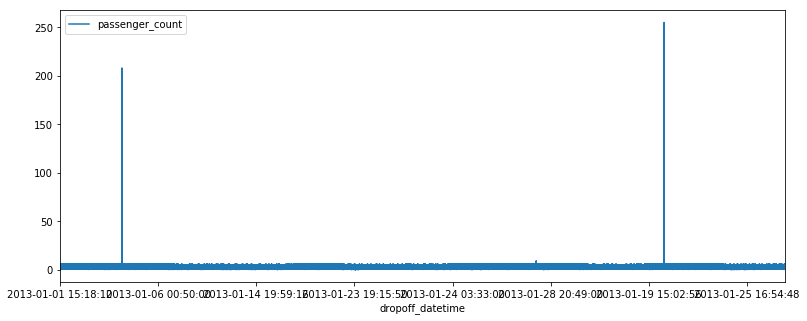

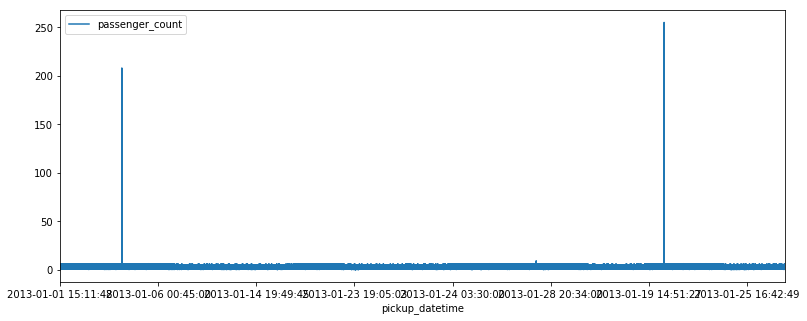

In [0]:
df.plot.line(x='dropoff_datetime', y='passenger_count', figsize=(13,5))
df.plot.line(x='pickup_datetime', y='passenger_count', figsize=(13,5))

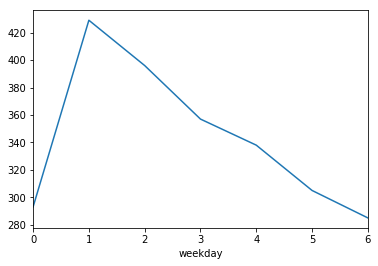

In [0]:
estePorDia['passenger_count'].sum().plot.line()

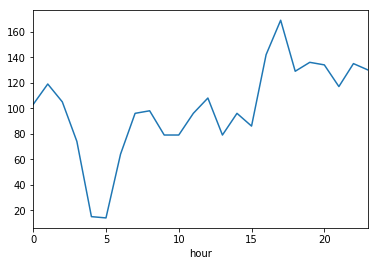

In [0]:
estePorHora['passenger_count'].sum().plot.line()

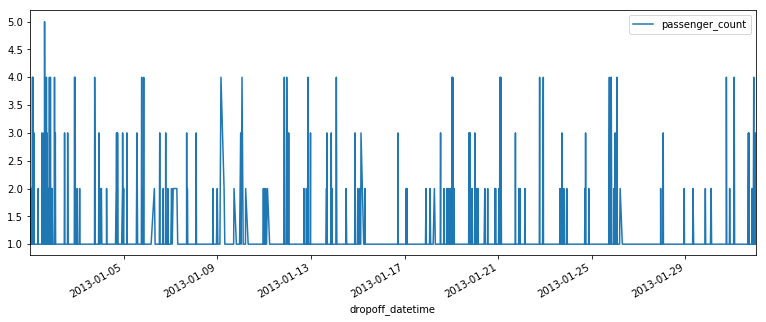

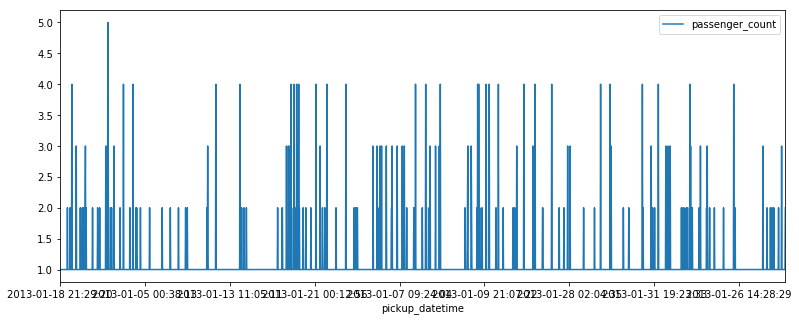

In [0]:
estos.plot.line(x='dropoff_datetime', y='passenger_count', figsize=(13,5))
estos.plot.line(x='pickup_datetime', y='passenger_count', figsize=(13,5))

#10. Elegir el vehiculo con mas viajes.
En cada mes y graficar en un mapa los sitios donde se suben pasajeros agrupados por dia de la semana (un color distinto para cada dia) hora del dia (un color distinto para cada intervalo de cuatro horas,00:00 - 03:59, 04:00--07:59, 08:00-11:59, etc.)

#11.  Repetir para las posiciones donde se bajan los pasajeros para el mismo vehiculo.

In [0]:
from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show

In [0]:
NYC = x_range, y_range = ((-8242000,-8210000), (4965000,4990000))

plot_width  = int(750)
plot_height = int(plot_width//1.2)

def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None

    p.add_tools(BoxZoomTool(match_aspect=True))

    return p

options = dict(line_color=None, fill_color='blue', size=5)

In [0]:
from bokeh.tile_providers import STAMEN_TERRAIN
output_notebook()
muestras = este.sample(n=20000)
p= base_plot()
p.add_tile(STAMEN_TERRAIN)

show(p)

Loading BokehJS ...

NameError: ignored